In [1]:
MODULE_DIR = "D:\\synthea-master\\src\\main\\resources\\modules" # "D:\synthea_20221107\synthea_modules"

In [2]:
import os
import json
import pandas as pd

def get_module_name(mod_path):
    return mod_path.replace(MODULE_DIR + os.path.sep, '').replace(os.path.sep, ':').replace('.json', '')


def print_outline(elem, k='ROOT', depth=0):
    indent = ''.join(["\t" for i in range(depth)])
    if type(elem) == str:
        print(indent, f'{k}: "{elem}" <str>')
    elif type(elem) == int:
        print(indent, f'{k}: {elem} <int>')
    elif type(elem) == float:
        print(indent, f'{k}: {elem} <float>')
    elif type(elem) == bool:
        print(indent, f'{k}: {elem} <bool>')
    elif type(elem) == list:
        print(indent, k, 'LIST')
        for vv in elem:
            print_outline(vv, 'item', depth+1)
    elif type(elem) == dict:
        print(indent, f'"{k}"', '<dict>')
        for k, vv in elem.items():
            print_outline(vv, k, depth+1)
    else:
        print(indent, k, ':', type(elem), '<THIS IS NEW!>')


def find_attribute_usage(node, path='/'):
    path = path.lower()
    values = set()
    if type(node) == list:
        for child in node:
            child_values = find_attribute_usage(child, path=path)
            if len(child_values) > 0:
                values = values.union(child_values)
    elif type(node) == dict:
        direction = 'unknown'
        if 'condition' in path:
            direction = 'get'
        elif 'type' in node and node['type'] == 'SetAttribute':
            direction = 'set'
        elif 'type' in node and node['type'] == 'Observation':
            direction = 'observation'
        elif 'outputs' in path:
            direction = 'observation' # 'outputs'
        elif 'observation' in path:
            direction = 'observation'
        elif 'attachment' in path:
            direction = 'observation'
        elif 'type' in node and node['type'] == 'Counter':
            direction = 'set'  # node['action']  # usually 'increment' or 'decrement'
        elif 'allow' in path:  # Guard node
            direction = 'get' # 'allow'
        elif 'transition' in path:
            direction = 'get'  # 'transition' # 'distributed_transition, complex_transition
        if 'attribute' in node:
            value_key = 'attribute:' + node['attribute'] + ':' + direction
            values.add(value_key)
        # handle Active Condition, Active Medication, Age, Gender, Race and Vital Sign
        elif 'condition_type' in node:
            if node['condition_type'] == 'Active Condition':
                child_values = ['condition:' + code['display'] + ':get' for code in node['codes']]
                if len(child_values) > 0:
                    values = values.union(child_values)
            elif node['condition_type'] == 'Active Medication':
                child_values = ['medication:' + code['display'] + ':get' for code in node['codes']]
                if len(child_values) > 0:
                    values = values.union(child_values)
            elif node['condition_type'] in ['Age', 'Gender', 'Race']:
                value_key = 'demographic:' + node['condition_type'] + ':get'
                values.add(value_key)
            # elif node['condition_type'] == 'Vital Sign'
        for k, child in node.items():
            child_values = find_attribute_usage(child, path=path + '/' + k)
            if len(child_values) > 0:
                values = values.union(child_values)
        
    return values
    

In [3]:
# To Do: where do demographic variables like age and gender come in?

In [4]:
module_attributes = {}

def process_module_file(mod_path):
    mod_name = get_module_name(mod_path)
    
    with open(mod_path, 'r', encoding="utf8") as mod_fh:
        mod_js = json.load(mod_fh)

    mod_attrib = find_attribute_usage(mod_js)

    module_attributes[mod_name] = mod_attrib


for fd in os.listdir(MODULE_DIR):
    full_path = os.path.join(MODULE_DIR, fd)
    if os.path.isdir(full_path):
        print(f"# {fd}:")
        for child_dir in os.listdir(full_path):
            if child_dir.endswith('.json'):
                print(f"\t* {child_dir}")
                child_path = os.path.join(MODULE_DIR, fd, child_dir)
                process_module_file(child_path)
    elif full_path.endswith('.json'):
        print(f"* {fd}")
        process_module_file(full_path)

* acute_myeloid_leukemia.json
* allergic_rhinitis.json
# allergies:
	* allergy_panel.json
	* drug_allergy_incidence.json
	* environmental_allergy_incidence.json
	* food_allergy_incidence.json
	* immunotherapy.json
	* outgrow_env_allergies.json
	* outgrow_food_allergies.json
	* severe_allergic_reaction.json
* allergies.json
# anemia:
	* anemia_sub.json
* anemia___unknown_etiology.json
* appendicitis.json
* asthma.json
* atopy.json
* atrial_fibrillation.json
* attention_deficit_disorder.json
# breast_cancer:
	* chemotherapy_breast.json
	* hormonetherapy_breast.json
	* hormone_diagnosis.json
	* surgery_therapy_breast.json
	* tnm_diagnosis.json
* breast_cancer.json
* bronchitis.json
* cerebral_palsy.json
* chronic_kidney_disease.json
* colorectal_cancer.json
* congestive_heart_failure.json
# contraceptives:
	* clear_contraceptive.json
	* female_sterilization.json
	* implant_contraceptive.json
	* injectable_contraceptive.json
	* intrauterine_device.json
	* male_sterilization.json
	* oral_co

KeyError: 'codes'

In [5]:
edge_types = []

for my_key, my_set in module_attributes.items():
    for my_edge in my_set:
        my_type =  my_edge.split(':')[1]
        if my_type == 'unknown':
            print('attribute of unknown type in module', my_key)
        edge_types.append(my_type )

from collections import Counter
Counter(edge_types)

Counter({'Age': 42,
         'Gender': 37,
         'ckd': 27,
         'pregnant': 20,
         'contraceptive_type': 12,
         'anemia': 11,
         'Race': 9,
         'hypertension': 9,
         'smoker': 8,
         'hospice': 8,
         'atopic': 7,
         'hospice_reason': 7,
         'diabetes': 7,
         'chf_med_step': 6,
         'hiv_cd4': 6,
         'veteran': 5,
         'Injury of kidney (disorder)': 5,
         'otc_pain_reliever': 5,
         'antibiotic_prescription': 5,
         'opioid_prescription': 5,
         'hiv_rapid_start': 5,
         'hiv_viral_load': 5,
         'hiv_continuous_art': 5,
         'visit_allergist': 4,
         'colorectal_cancer_stage': 4,
         'nyha_class': 4,
         'Acute respiratory failure (disorder)': 4,
         'covid19_death': 4,
         'coronary_heart_disease': 4,
         'lung_cancer': 4,
         'chf': 4,
         'covid19_severity': 4,
         'covid19_ddimer': 4,
         'stemi_cardiology_approach': 4,
  

In [6]:
module_attributes

{'acute_myeloid_leukemia': {'attribute:levofloxacin:get',
  'condition:Bacteremia (finding):get',
  'demographic:Gender:get',
  'medication:levofloxacin 500 MG Oral Tablet:get'},
 'allergic_rhinitis': {'attribute:atopic:get',
  'attribute:visit_allergist:set',
  'condition:Allergy to grass pollen:get',
  'condition:Allergy to mould:get',
  'condition:Allergy to tree pollen:get',
  'condition:Dander (animal) allergy:get',
  'condition:House dust mite allergy:get',
  'demographic:Age:get'},
 'allergies:allergy_panel': {'condition:Allergy to bee venom:get',
  'condition:Allergy to dairy product:get',
  'condition:Allergy to eggs:get',
  'condition:Allergy to fish:get',
  'condition:Allergy to grass pollen:get',
  'condition:Allergy to mould:get',
  'condition:Allergy to nut:get',
  'condition:Allergy to peanuts:get',
  'condition:Allergy to soya:get',
  'condition:Allergy to tree pollen:get',
  'condition:Allergy to wheat:get',
  'condition:Dander (animal) allergy:get',
  'condition:House

In [7]:
def as_edge_list(mod_attr):
    edge_list = []
    for module, edges in mod_attr.items():
        module_name = f"module|{module}"
        for edge in edges:
            type, attribute, direction = edge.split(':')
            attribute_name = f"{type}|{attribute}"
            # print(module_name, attribute_name, direction)
            if direction == 'get':
                edge_list.append({'from': attribute_name, 'to': module_name})
            elif direction == 'set':
                edge_list.append({'from': module_name, 'to': attribute_name})
    return edge_list

node_edges = pd.DataFrame( as_edge_list(module_attributes) )
node_edges

,from,to
0,condition|Bacteremia (finding),module|acute_myeloid_leukemia
1,demographic|Gender,module|acute_myeloid_leukemia
2,medication|levofloxacin 500 MG Oral Tablet,module|acute_myeloid_leukemia
3,attribute|levofloxacin,module|acute_myeloid_leukemia
4,condition|Allergy to tree pollen,module|allergic_rhinitis
...,...,...
866,attribute|sleep_apnea_treatment,module|sleep_apnea
867,attribute|years_until_sleep_apnea_renewal,module|sleep_apnea
868,attribute|chf,module|sleep_apnea
869,attribute|snf_days,module|snf:skilled_nursing_facility


In [8]:
# filter out selected topics

remove_me_patterns = ['covid19', 'condition', 'medication']
for remove_me_pattern in remove_me_patterns:
    node_edges = node_edges[ [remove_me_pattern not in row['from'] and remove_me_pattern not in row['to'] for row in node_edges.to_dict(orient='records')] ]

In [113]:
node_id = {}
next_node_id = 0

for node_name in [*node_edges['from'].tolist(), *node_edges['to'].tolist()]:
    if node_name not in node_id:
        node_id[node_name] = next_node_id
        next_node_id += 1

edges = pd.DataFrame.from_dict({'from':[node_id[nn] for nn in node_edges['from']], 
                                'to': [node_id[nn] for nn in node_edges['to']]}, 
                               orient='columns')

edges['weight'] = 1

nodes = pd.DataFrame([{'id':v, 'name':k} for k, v in node_id.items()])

nodes['category'] = [nn.split('|')[0] for nn in nodes['name']]

category_color = {'module':'#F0F080', 'attribute':'#D0F0D0', 'medication':'#F0D0F0', 'condition':'#D0F0F0', 'demographic':'#A0A0F0'}
category_shape = {'module':'box', 'attribute':'ellipse', 'medication':'ellipse', 'condition':'ellipse', 'demographic':'circle'}
nodes['color'] = [ category_color[cat] for cat in nodes['category']]
nodes['shape'] = [ category_shape[cat] for cat in nodes['category']]


# highlight nodes of interest: 
sn_color = '#F08080'
special_node_colors = {'sdoh_hrsn':sn_color, 'neuropathy':sn_color, 'smoker':sn_color, 
                       '\bdiabetes\b': sn_color, 'diabetes_amputation_necessary':sn_color,
                       'marital_status': sn_color, '\bhomeless\b': sn_color,
                       'ckd': sn_color, 'bmi_percentile': sn_color,
                       'age':sn_color, 'gender': sn_color}
# psychosocial, homeless

import regex
for pattern, highlight_color in special_node_colors.items():
    row_indexer = [ bool(regex.search(pattern, nm)) for nm in nodes['name'] ]
    nodes.loc[row_indexer, 'color'] = highlight_color


nodes['label'] = [nn.split('|')[1] for nn in nodes['name']]
nodes['title'] = [nn.split('|')[1] + "\n" + nn.split('|')[0] for nn in nodes['name']]

nodes

,id,name,category,color,shape,label,title
0,0,demographic|Gender,demographic,#A0A0F0,circle,Gender,Gender\ndemographic
1,1,attribute|levofloxacin,attribute,#D0F0D0,ellipse,levofloxacin,levofloxacin\nattribute
2,2,demographic|Age,demographic,#A0A0F0,circle,Age,Age\ndemographic
3,3,module|allergic_rhinitis,module,#F0F080,box,allergic_rhinitis,allergic_rhinitis\nmodule
4,4,attribute|atopic,attribute,#D0F0D0,ellipse,atopic,atopic\nattribute
...,...,...,...,...,...,...,...
363,363,module|mTBI,module,#F0F080,box,mTBI,mTBI\nmodule
364,364,attribute|osteoporosis_encounter_reason,attribute,#D0F0D0,ellipse,osteoporosis_encounter_reason,osteoporosis_encounter_reason\nattribute
365,365,attribute|number_of_children,attribute,#D0F0D0,ellipse,number_of_children,number_of_children\nattribute
366,366,module|self_harm,module,#F0F080,box,self_harm,self_harm\nmodule


In [114]:
nodes[ ['bmi' in nn for nn in nodes['name']] ]

,id,name,category,color,shape,label,title
212,212,attribute|bmi_percentile,attribute,#F08080,ellipse,bmi_percentile,bmi_percentile\nattribute


In [115]:
edges

,from,to,weight
0,0,271,1
1,1,271,1
2,2,3,1
3,3,10,1
4,4,3,1
...,...,...,...
579,267,266,1
580,268,266,1
581,175,266,1
582,269,270,1


In [116]:
from ThoughtGraph import ThoughtGraph, tg_utils

In [117]:
tg = ThoughtGraph(nodes, edges)

tg.export_to_vis_js('Synthea Modules and Attributes', 'synthea_modules_and_attributes_graph_no_covid19_age.html')

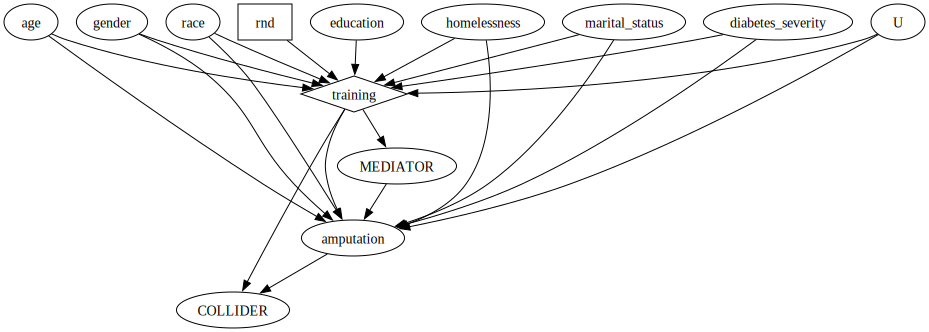

In [93]:
import graphviz as gr

# amputation smoking diabetes_severity homelessness age gender race zip_code
g_amputation = gr.Digraph()


#https://synthetichealth.github.io/module-builder/#metabolic_syndrome_care 'Amputation_Necessary' module, attribute 'diabetes_amputation_necessary'

g_amputation.node('rnd', shape='box')
g_amputation.node('training', shape='diamond') # label='wound care training'

g_amputation.edge("rnd", "training")
g_amputation.edge("training", "amputation")

g_amputation.edge("age", "amputation")
g_amputation.edge("age", "training")

g_amputation.edge("gender", "amputation")
g_amputation.edge("gender", "training")

g_amputation.edge("race", "amputation")
g_amputation.edge("race", "training")

g_amputation.edge("homelessness", "amputation")
g_amputation.edge("homelessness", "training")

g_amputation.edge("marital_status", "amputation")
g_amputation.edge("marital_status", "training")

g_amputation.edge("diabetes_severity", "amputation")  # the analysis will only be able to see diagnoses, not attributes.
g_amputation.edge("diabetes_severity", "training")

g_amputation.edge("U", "amputation")
g_amputation.edge("U", "training")

# Maybe a collider could be something like "doctor visits"?
# Should we add an 'infection"? node before amputation (leads to more doctor visits, not counting the actual amputation).
# Would training lead to more doctor visits or fewer?
# The collider could be someone's suggested engineered feature.
g_amputation.edge("training", "COLLIDER")
g_amputation.edge("amputation", "COLLIDER")

# Mediator might be something like use of wound care products?
g_amputation.edge("training", "MEDIATOR")
g_amputation.edge("MEDIATOR", "amputation")

# Predictor of training adherance but not otherwise of outcome; should not be included as a covariate.
g_amputation.edge("education", "training")

# Alternative outcome?
# Training cost depends on how many people you train; minimize this by focusing on patients likely to have bad outcomes, or on their way to having bad outcomes.
# Deciding when to intervene is an optimization problem. Machine learning might be helpful.
# g_amputation.edge("training", "COST")
# g_amputation.edge("amputation", "COST")
# g_amputation.edge("MEDIATOR", "COST")

g_amputation



In [87]:
nodes[ [ 'education' in nn for nn in nodes['name'] ] ]

,id,name,category,color,shape,label,title
105,105,attribute|education,attribute,#D0F0D0,ellipse,education,education\nattribute


In [105]:
module_file = "C:\\Users\\rmhorton\\Documents\\EMRTS\\leg_wounds_SDOH\\wound_infection\\wound_infection.json"

with open(module_file, 'r', encoding='utf8') as jsfh:
    module = json.load(jsfh)

In [106]:
module

{'name': 'Wound Infection Progression',
 'remarks': ['Models wound infection status. Currently only includes diabetic and healthy patients.'],
 'states': {'Initial': {'name': 'Initial',
   'type': 'Initial',
   'direct_transition': 'Begin_Loop'},
  'Begin_Loop': {'name': 'Begin_Loop',
   'type': 'Simple',
   'remarks': ['Separate path for patients with selected chronic diseases.'],
   'conditional_transition': [{'transition': 'Determine Wound Infection Diabetic',
     'condition': {'condition_type': 'Attribute',
      'attribute': 'diabetes',
      'operator': '==',
      'value': True}},
    {'transition': 'Determine Wound Infection Nondiabetic'}]},
  'Determine Wound Infection Diabetic': {'name': 'Determine Wound Infection Diabetic',
   'type': 'Simple',
   'lookup_table_transition': {'type': 'Table',
    'transitions': [{'transition': 'wound_infection_next_0',
      'lookup_table_name': 'wound_infection_diabetic.csv',
      'default_probability': 1},
     {'transition': 'wound_infec

An 'attribute' member is an input if
* it is in a dict node called 'condition', or
* it is in a list called 'item' in a dict called 'consitions'

It is an output if:
* it is in a dict node that also has 'type' equal to 'SetAttribute'.


# To Do:
* Figure out that to do with the attributes that are still 'unknowm'
* Handle other global state variables:
  - vital signs
  - what else??


gallstones.json  has 'Attributes' and simulated ecg results